<a href="https://colab.research.google.com/github/kazuki-komori/coursera/blob/main/regression/CSR_regression_w2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第2回 勉強会

## 住宅価格予測のためのさまざまな重回帰モデルの探索

### TODO

- Use SFrames to do some feature engineering

- Use built-in Turi Create (or otherwise) functions to compute the regression weights (coefficients)

- Given the regression weights, predictors and outcome write a function to compute the Residual Sum of Squares

- Look at coefficients and interpret their meanings

- Evaluate multiple models via RSS

## setup

In [4]:
!unzip -q /content/drive/MyDrive/coursera/home_data.zip

In [5]:
!pip install turicreate

     |████████████████████████████████| 92.0 MB 16 kB/s 
     |████████████████████████████████| 322 kB 51.4 MB/s 
     |████████████████████████████████| 3.6 MB 59.3 MB/s 
     |████████████████████████████████| 3.5 MB 43.5 MB/s 
     |████████████████████████████████| 86.4 MB 64 kB/s 
     |████████████████████████████████| 18.3 MB 495 kB/s 
     |████████████████████████████████| 3.8 MB 42.2 MB/s 
     |████████████████████████████████| 449 kB 71.5 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 2.9 MB 30.7 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=eea7f70f2b76700b0ba50db1e4ea5403413dbb9ddd3ee46d4067891af4048b4d
  Stored in directory: /root/.cache/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320859 sha256=4a48e2e7ae2

In [6]:
import turicreate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## (1) データの読み込み

In [7]:
df_house = turicreate.SFrame('/content/home_data.sframe')
df_house.head(5)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900.0,3.0,1.0,1180.0,5650.0,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000.0,3.0,2.25,2570.0,7242.0,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000.0,2.0,1.0,770.0,10000.0,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000.0,4.0,3.0,1960.0,5000.0,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000.0,3.0,2.0,1680.0,8080.0,1.0,0
view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat
0,3,7.0,1180.0,0.0,1955.0,0.0,98178,47.51123398
0,3,7.0,2170.0,400.0,1951.0,1991.0,98125,47.72102274
0,3,6.0,770.0,0.0,1933.0,0.0,98028,47.73792661
0,5,7.0,1050.0,910.0,1965.0,0.0,98136,47.52082


## (2) データの分割

In [8]:
df_train, df_test = df_house.random_split(.8, seed=0)

## (3) 新しい特徴量の作成

特徴量を新たに作成することによって, 既存変数以外の交互作用も考慮することができる


- 寝室を2乗すると、1^2=1ですが、4^2=16なので、あまり寝室がない（例えば1）と寝室が多い（例えば4）の隔たりが大きくなる。その結果、この変数は多くのベッドルームを持つ住宅に影響を与えることになる

- ベッドルームの回数バスルームは、いわゆる「相互作用」変数です。両方が大きいと大きくなる

- 平方フィートの対数を取ると、大きな値を近づけ、小さな値を広げる効果がある

- 経度に緯度を足すのは非科学的だが、とりあえずやってみる（理由は後ほどわかるでしょう）

In [9]:
def create_new_feature(df):
  df["bedrooms_squared"] = df["bedrooms"] * df["bedrooms"]
  df["bed_bath_rooms"] = df["bedrooms"] * df["bathrooms"]
  df["log_sqft_living"] = np.log(df["sqft_living"].to_numpy())
  df["lat_plus_long"] = df["lat"] + df["long"]
  return df

df_train = create_new_feature(df_train)
df_test = create_new_feature(df_test)
df_train.head(5)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900.0,3.0,1.0,1180.0,5650.0,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000.0,3.0,2.25,2570.0,7242.0,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000.0,2.0,1.0,770.0,10000.0,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000.0,4.0,3.0,1960.0,5000.0,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000.0,3.0,2.0,1680.0,8080.0,1.0,0
view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat
0,3,7.0,1180.0,0.0,1955.0,0.0,98178,47.51123398
0,3,7.0,2170.0,400.0,1951.0,1991.0,98125,47.72102274
0,3,6.0,770.0,0.0,1933.0,0.0,98028,47.73792661
0,5,7.0,1050.0,910.0,1965.0,0.0,98136,47.52082


## (4) テストデータの新しく作成した変数の平均

In [10]:
def calc_new_feature_ave(df):
  _target_cols = [
                  "bedrooms_squared", 
                  "bed_bath_rooms", 
                  "log_sqft_living",
                  "lat_plus_long"
                  ]
  for _col in _target_cols:
    _mean = df[_col].mean()
    print(f"{_col}: {np.round(_mean, 2)}\n")

calc_new_feature_ave(df_test)

bedrooms_squared: 12.45

bed_bath_rooms: 7.5

log_sqft_living: 7.55

lat_plus_long: -74.65



### 作成した特徴量の分布の変化を見てみる

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 50.0)]

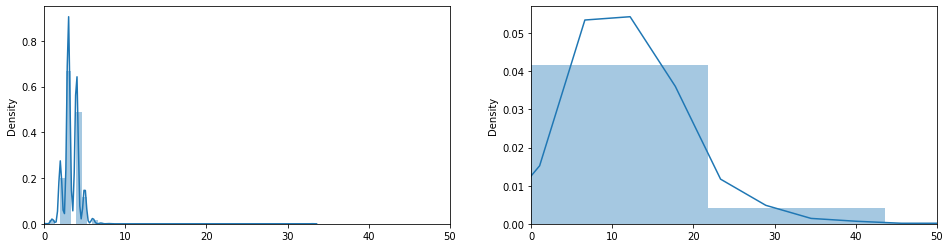

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_test["bedrooms"], ax=axes[0])
axes[0].set(xlim=(0, 50))
sns.distplot(df_test["bedrooms_squared"], ax=axes[1])
axes[1].set(xlim=(0, 50))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 15.0)]

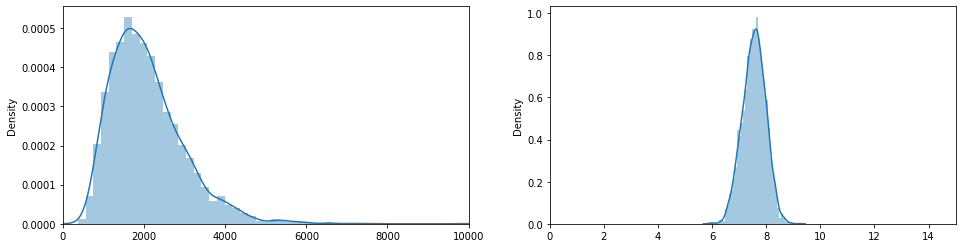

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_test["sqft_living"], ax=axes[0],)
axes[0].set(xlim=(0, 10000))
sns.distplot(df_test["log_sqft_living"], ax=axes[1])
axes[1].set(xlim=(0, 15))

## (5) turicreate を使って回帰係数を推定してみる

In [13]:
def create_liner_model_by_turicreate(features):
  model = turicreate.linear_regression.create(df_train, target="price", features=features, validation_set=None, verbose=False)
  print(f"created model !\n {model.coefficients}\n")
  return model

feature_1 = ["sqft_living", "bedrooms", "bathrooms", "lat", "long"]
feature_2 = ["sqft_living", "bedrooms", "bathrooms", "lat", "long", "bed_bath_rooms"]
feature_3 = ["sqft_living", "bedrooms", "bathrooms", "lat", "long", "bed_bath_rooms", "bedrooms_squared", "log_sqft_living", "lat_plus_long"]

model1 = create_liner_model_by_turicreate(feature_1)
model2 = create_liner_model_by_turicreate(feature_2)
model3 = create_liner_model_by_turicreate(feature_3)

created model !
 +-------------+-------+---------------------+--------------------+
|     name    | index |        value        |       stderr       |
+-------------+-------+---------------------+--------------------+
| (intercept) |  None | -56140675.741145164 | 1649985.420232753  |
| sqft_living |  None |  310.26332577692176 | 3.188829604072599  |
|   bedrooms  |  None |  -59577.11606759663 | 2487.279773224208  |
|  bathrooms  |  None |  13811.840541653299 | 3593.5421329676874 |
|     lat     |  None |  629865.7894714857  | 13120.71003228041  |
|     long    |  None | -214790.28516471686 | 13284.285159947443 |
+-------------+-------+---------------------+--------------------+
[6 rows x 4 columns]


created model !
 +----------------+-------+---------------------+--------------------+
|      name      | index |        value        |       stderr       |
+----------------+-------+---------------------+--------------------+
|  (intercept)   |  None |  -54410676.11184308 | 1650405.165369

## (6) (7) (8) 回帰係数の考察

`bathrooms` の回帰係数

- Model 1: `positive`
- Model 2: `negative`

回帰係数の正負は異なる。
`bedrooms` と `price` の相関は低い？？
`bedrooms` と `bathrooms` の相関は強い

### 回帰係数を見てみる

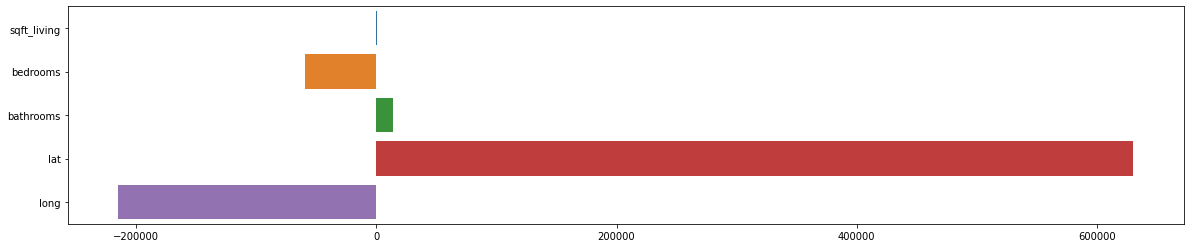

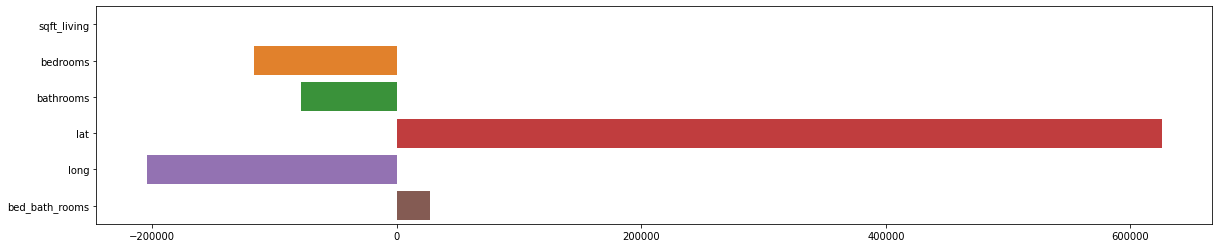

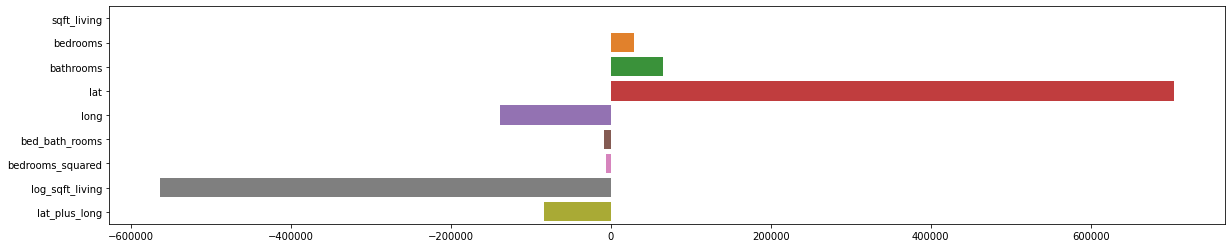

In [14]:
def show_coef(model):
  _coef = model.coefficients.to_numpy()
  fig, axes = plt.subplots(figsize=(20, 4))
  sns.barplot(y=_coef[1:, 0], x=_coef[1:, 2])
  plt.show()

show_coef(model1)
show_coef(model2)
show_coef(model3)

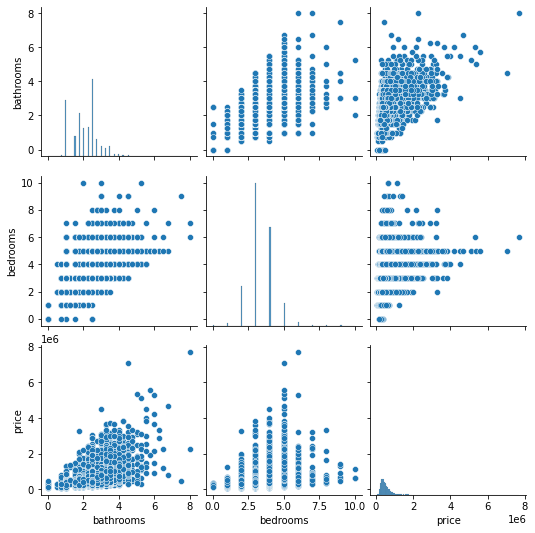

In [15]:
sns.pairplot(df_train[["bathrooms", "bedrooms", "price"]].to_dataframe())

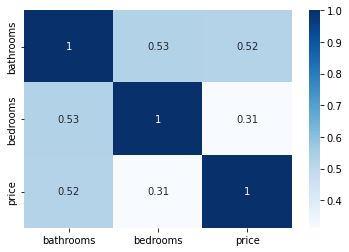

In [22]:
sns.heatmap(df_train[["bathrooms", "bedrooms", "price"]].to_dataframe().corr(), cmap='Blues', annot=True)
plt.show()

## (9) (10) Training data を使用して RSS を計算する

model3 の RSS が最も低い

In [34]:
def calc_rss(model, df):
  _price = df["price"].to_numpy()
  _pred = model.predict(df).to_numpy()
  _rss = ((_price - _pred) ** 2).sum()
  print(f"RSS: {_rss}\n")

calc_rss(model1, df_train)
calc_rss(model2, df_train)
calc_rss(model3, df_train)

RSS: 971328233545433.9

RSS: 961592067857507.1

RSS: 905276314551640.5



## (11) (12) Test data を使用して RSS を計算する

model2 が最も小さい

In [35]:
calc_rss(model1, df_test)
calc_rss(model2, df_test)
calc_rss(model3, df_test)

RSS: 226568089093160.38

RSS: 224368799993970.94

RSS: 251829318963159.3

